# Local polar order parameter

In simulations we observe that, at a given density, clusters of elongated cells with polar order emerge, but no global polar order is present since different clusters point in different directions. To characterize the transition from a system with elongated cells with local polar order (coexisting with round ones) to a system where all cells are round, we introduce a local order parameter.

We define the polarization of each cell as
$$
\mathbf{p}_i = 
\begin{cases}
(\cos \varphi_i, \sin \varphi_i) & \text{if the cell is elongated},\\
(0,0) & \text{if the cell is round}.
\end{cases}
$$

With this definition,

$$
\frac{1}{N}\left| \sum_{i=1}^{N} \mathbf{p}_i \right|
= \frac{1}{N}\sqrt{\left(\sum_{i=1}^{N_e}\sin\varphi_i\right)^2 + \left(\sum_{i=1}^{N_e}\cos\varphi_i\right)^2}
= \hat P,
$$

so the global order parameter $\hat P$ is simply the average polarization over all cells.  

Since only local order is observed, we instead define for each cell $j$ the local order parameter

$$
\hat P_{\text{local},j} = \frac{1}{N_j}\left| \sum_{i=1}^{N_j} \mathbf{p}_i \right|,
$$

where $N_j$ is the number of cells in the neighborhood of cell $j$. The system-wide local polar order parameter is then

$$
\hat P_{\text{local}} = \frac{1}{N}\sum_{j=1}^N \hat P_{\text{local},j}.
$$

This quantity measures typical local alignment and is thus more appropriate for characterizing systems with cluster-level order but no global polarization.


In [1]:
# import the libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define parameters useful for the local order parameter
grid_cube_size = 2*np.sqrt(2.7)  # biggest size of the elongated cells

# And other parameters that were defined in the simulations
cell_area = np.pi
# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

In [3]:
def load_data(dens, seed, num_cells):
    """
    Load positions, orientations and aspect ratios, and construct
    the polarization vector for each cell (elongated or round).
    """
    dens_folder = f"{dens:.3f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"

    folder = f"data/{num_cells_folder}/{dens_folder}/dat_final/"
    files = [f for f in os.listdir(folder) if f"With_Shrinking_rng_seed={seed}" in f]
    if not files:
        print(f"No file found for seed {seed}")
        return None, None, None

    dat_file = os.path.join(folder, max(files))
    df = pd.read_csv(dat_file)

    positions = df[["position_x", "position_y"]].values
    orientations = df["orientation"].values
    aspect_ratios = df["aspect_ratio"].values

    # Build polarization vectors for ALL cells
    p_all = np.zeros((len(positions), 2))
    elong_mask = ~np.isclose(aspect_ratios, 1)
    p_all[elong_mask, 0] = np.cos(orientations[elong_mask])
    p_all[elong_mask, 1] = np.sin(orientations[elong_mask])
    # round cells keep (0,0)

    return positions, p_all

In [4]:
def build_grid(number_cells, cell_area, dens, grid_cube_size, positions):
    """ 
    Function that builds the grid. It needs to recalculate the cube size
    in order to have an integer number of buckets.
    """
    # Calculate the bounds of the grid
    bounds = np.sqrt(number_cells * cell_area / dens)
    # Calculate the number of buckets
    number_of_buckets = int(np.floor(bounds / grid_cube_size))
    # Update the cube_size in order to have
    # an integer number of buckets completed
    cube_size = bounds/number_of_buckets
    # Create the grid
    grid = {}
    for i, pos in enumerate(positions):
        key = tuple(np.floor(pos / cube_size).astype(int) % number_of_buckets)
        if key not in grid:
            grid[key] = []
        grid[key].append(i)
    return grid, number_of_buckets, cube_size

In [5]:
def calculate_local_order(positions, p_all, cube_size, number_of_buckets, grid):
    """
    Calculates the local order parameters given the grid and all polarization vectors.
    Returns an array with the local parameter vector for every cell.
    """
    offsets = [(dx, dy) for dx in [-1,0,1] for dy in [-1,0,1]]
    p_local = np.zeros_like(p_all)

    for i, pos in enumerate(positions):
        key = tuple(np.floor(pos / cube_size).astype(int) % number_of_buckets)
        neighbors_idx = []
        for dx, dy in offsets:
            neighbor_key = ((key[0]+dx) % number_of_buckets,
                            (key[1]+dy) % number_of_buckets)
            if neighbor_key in grid:
                neighbors_idx.extend(grid[neighbor_key])

        if len(neighbors_idx) == 0:
            continue

        # sum of polarizations in neighborhood
        p_sum = np.sum(p_all[neighbors_idx], axis=0)
        p_local[i] = p_sum / len(neighbors_idx)  # local average

    return p_local

In [6]:
def calculate_final_order(dens, seed, num_cells):
    """
    Calculates the average local order parameter for all cells.
    """
    positions, p_all = load_data(dens, seed, num_cells)
    if positions is None:
        return 0.0

    grid, number_of_buckets, cube_size = build_grid(num_cells, cell_area, dens, grid_cube_size, positions)

    p_local = calculate_local_order(positions, p_all, cube_size, number_of_buckets, grid)

    # Mean of magnitudes across all cells
    P_local = np.mean(np.linalg.norm(p_local, axis=1))
    return P_local

In [7]:
def create_dataframe_results(number_of_cells, density_list):
    """
    Create a DataFrame with the mean and std of the local order parameter
    for each density in density_list, averaged over all seeds.
    """   
    # DataFrame to store results
    df = pd.DataFrame(columns=["density", "mean_P_local", "std_P_local"])

    # Loop over densities and seeds
    for dens in density_list:
        P_local_list = []
        for seed in rng_seed:
            P_local = calculate_final_order(dens, seed, number_of_cells)
            P_local_list.append(P_local)
        mean_P_local = np.mean(P_local_list)
        std_P_local = np.std(P_local_list)
        df.loc[len(df)] = [dens, mean_P_local, std_P_local]
    return df

In [8]:
def plot_results(df, number_of_cells, color="red"):
    """
    Plot the mean and variance of the local order parameter as a function of density.
    """
    # Create folder if it doesn't exist
    num_cells_folder = f"N={number_of_cells:_}"
    graph_folder = f"graphs/{num_cells_folder}/local_order"
    os.makedirs(graph_folder, exist_ok=True)

    # Error bars
    error_P_local = df["std_P_local"] / np.sqrt(len(rng_seed))

    # Subplots 1x2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    axes[0].errorbar(df["density"], df["mean_P_local"], yerr=error_P_local, fmt='o-', color=color, capsize=3, markersize=5, label="P_local")
    axes[0].set_xlabel("Density ρ")
    axes[0].set_ylabel("P_local")
    axes[0].set_title("Mean ± Std Error")
    axes[0].legend()

    axes[1].plot(df["density"], df["std_P_local"]**2, 'o--', color=color, label="Var(P_local)")
    axes[1].set_xlabel("Density ρ")
    axes[1].set_ylabel("Variance")
    axes[1].set_title("Variance")
    axes[1].legend()

    fig.suptitle(f"Order parameters vs Density for N={number_of_cells}", fontsize=16)
    plt.savefig(f"{graph_folder}/P_local_N={number_of_cells}.png", dpi=600)
    plt.show()
    plt.close()

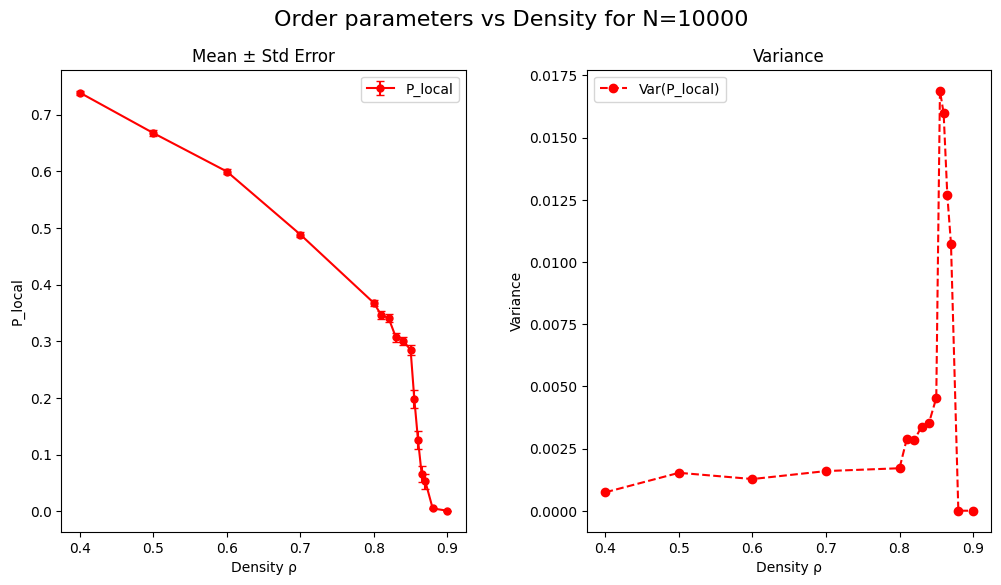

In [9]:
number_of_cells = 10_000

# List of densities to analyze
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.855, 0.86, 0.865, 0.87, 0.88, 0.9]

df_10000 = create_dataframe_results(number_of_cells, density_list)
plot_results(df_10000, number_of_cells)

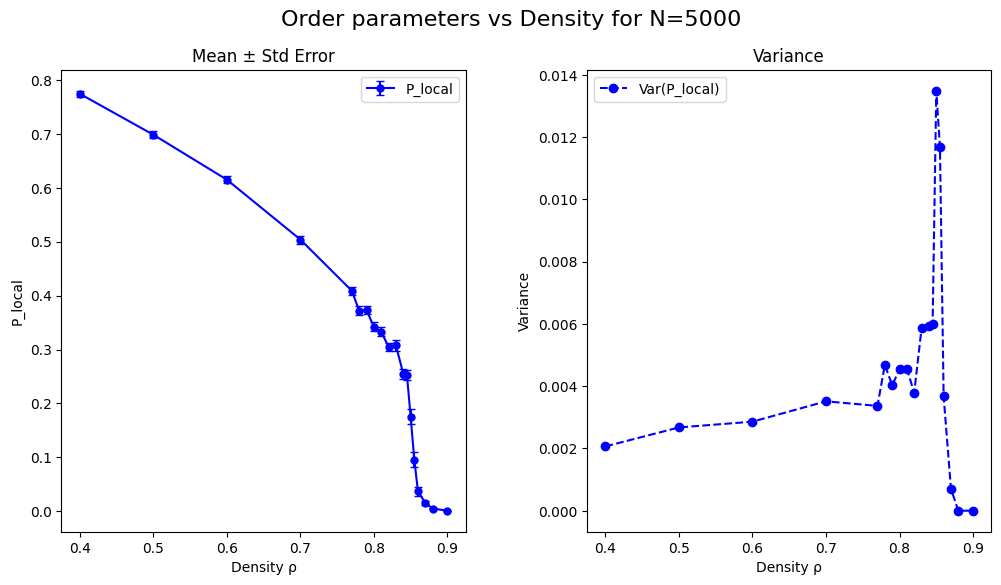

In [10]:
number_of_cells = 5_000

# List of densities to analyze
density_list = [0.4, 0.5, 0.6, 0.7, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.845, 0.85, 0.855, 0.86, 0.87, 0.88, 0.9]

df_5000 = create_dataframe_results(number_of_cells, density_list)
plot_results(df_5000, number_of_cells, color="blue")

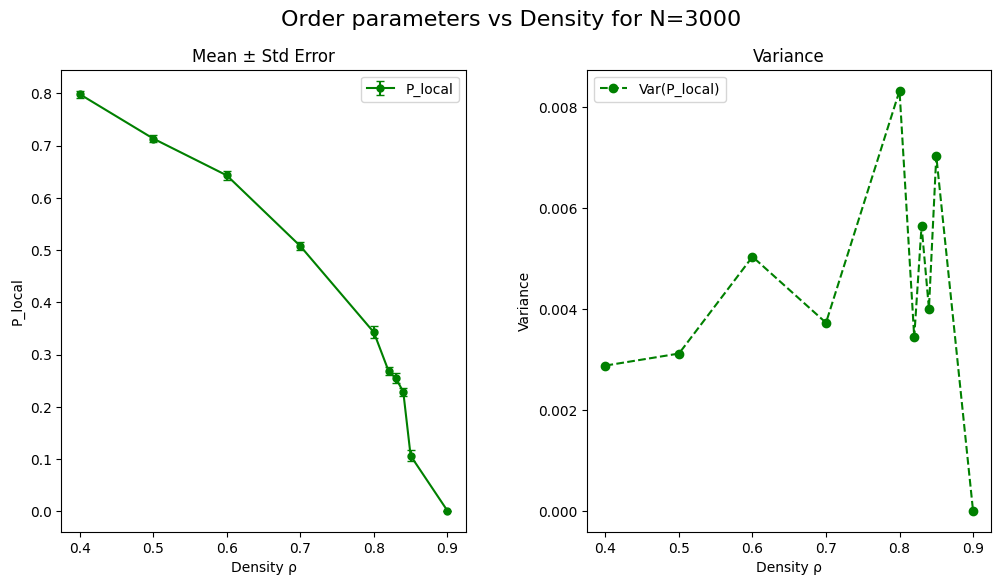

In [11]:
number_of_cells = 3_000

# List of densities to analyze
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.82, 0.83, 0.84, 0.85, 0.9]

df_3000 = create_dataframe_results(number_of_cells, density_list)
plot_results(df_3000, number_of_cells, color="green")

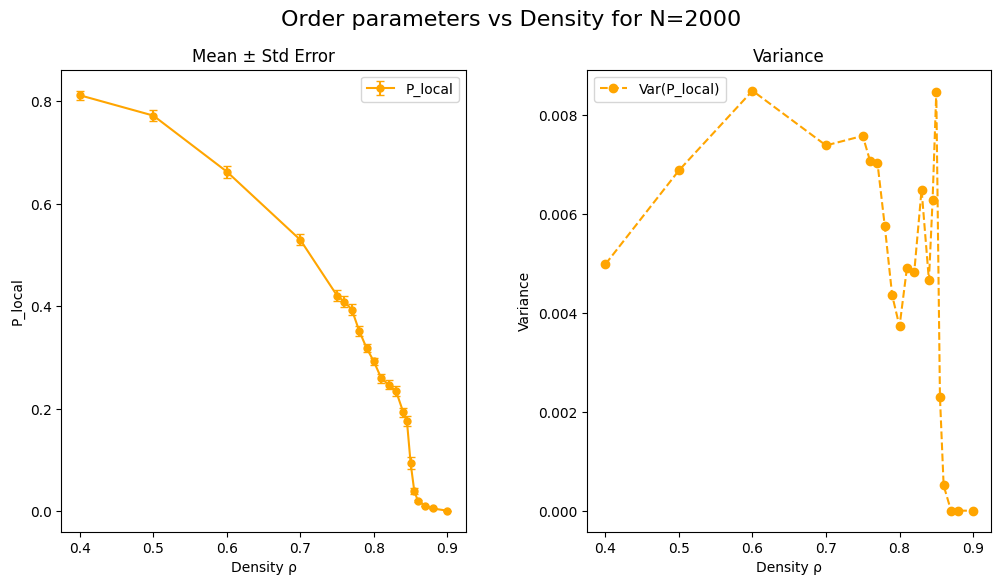

In [12]:
number_of_cells = 2_000

# List of densities to analyze
density_list = [0.4, 0.5, 0.6, 0.7, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.845, 0.85, 0.855, 0.86, 0.87, 0.88, 0.9]

df_2000 = create_dataframe_results(number_of_cells, density_list)
plot_results(df_2000, number_of_cells, color="orange")

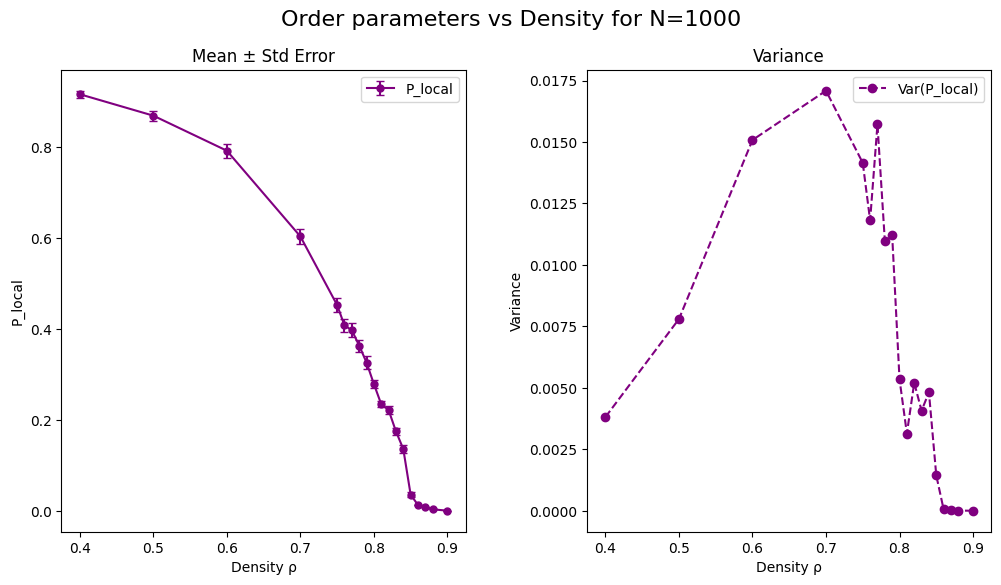

In [14]:
number_of_cells = 1_000

# List of densities to analyze
density_list = [0.4, 0.5, 0.6, 0.7, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]

df_1000 = create_dataframe_results(number_of_cells, density_list)
plot_results(df_1000, number_of_cells, color="purple")

In [15]:
def plot_for_every_N(df_1, df_2, df_3, df_4, df_5, N_1, N_2, N_3, N_4, N_5):
    """
    Plot the mean local order parameter for different numbers of cells
    on the same graph for comparison.
    """
    # 0.7 <= density <= 0.9
    # mask_1 = (df_1["density"] >= 0.7) & (df_1["density"] <= 0.9)
    # mask_2 = (df_2["density"] >= 0.7) & (df_2["density"] <= 0.9)
    # mask_3 = (df_3["density"] >= 0.7) & (df_3["density"] <= 0.9)
    # df_1 = df_1[mask_1]
    # df_2 = df_2[mask_2]
    # df_3 = df_3[mask_3]

    # Combined plot
    # Subplots 1x2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    axes[0].errorbar(df_1["density"], df_1["mean_P_local"], yerr=df_1["std_P_local"]/np.sqrt(len(rng_seed)), fmt='o-', color="red", capsize=3, markersize=5, label=f"N={N_1}")
    axes[0].errorbar(df_2["density"], df_2["mean_P_local"], yerr=df_2["std_P_local"]/np.sqrt(len(rng_seed)), fmt='o-', color="blue", capsize=3, markersize=5, label=f"N={N_2}")
    axes[0].errorbar(df_3["density"], df_3["mean_P_local"], yerr=df_3["std_P_local"]/np.sqrt(len(rng_seed)), fmt='o-', color="green", capsize=3, markersize=5, label=f"N={N_3}")
    axes[0].errorbar(df_4["density"], df_4["mean_P_local"], yerr=df_4["std_P_local"]/np.sqrt(len(rng_seed)), fmt='o-', color="orange", capsize=3, markersize=5, label=f"N={N_4}")
    axes[0].errorbar(df_5["density"], df_5["mean_P_local"], yerr=df_5["std_P_local"]/np.sqrt(len(rng_seed)), fmt='o-', color="purple", capsize=3, markersize=5, label=f"N={N_5}")

    axes[0].set_xlabel("Density ρ")
    axes[0].set_ylabel("P_local")
    axes[0].set_title(f"Mean P_local vs Density")
    axes[0].legend()

    axes[1].plot(df_1["density"], df_1["std_P_local"]**2, 'o--', color="red", label=f"N={N_1}")
    axes[1].plot(df_2["density"], df_2["std_P_local"]**2, 'o--', color="blue", label=f"N={N_2}")
    axes[1].plot(df_3["density"], df_3["std_P_local"]**2, 'o--', color="green", label=f"N={N_3}")
    axes[1].plot(df_4["density"], df_4["std_P_local"]**2, 'o--', color="orange", label=f"N={N_4}")
    axes[1].plot(df_5["density"], df_5["std_P_local"]**2, 'o--', color="purple", label=f"N={N_5}")
    axes[1].set_xlabel("Density ρ")
    axes[1].set_ylabel("Variance")
    axes[1].set_title("Variance")
    axes[1].legend()
    plt.grid()
    folder_path = f"graphs/N_comparison/local_order"
    os.makedirs(folder_path, exist_ok=True)
    plt.savefig(f"{folder_path}/P_local_comparison.png", dpi=600)
    plt.show()
    plt.close()

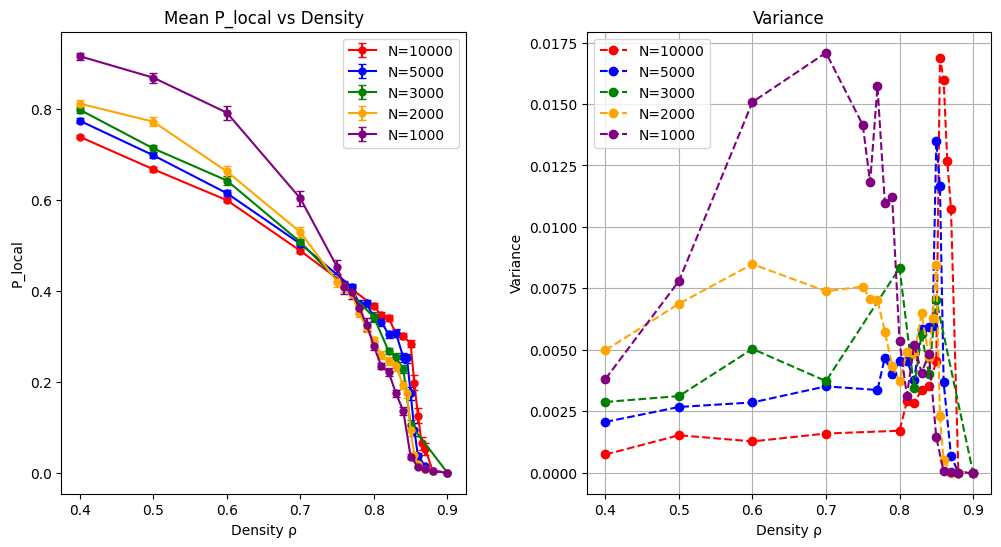

In [16]:
plot_for_every_N(df_10000, df_5000, df_3000, df_2000, df_1000, 10_000, 5_000, 3_000, 2_000, 1_000)